# Ultra pro 20


In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
from tensorflow.keras.utils import plot_model
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

In [ ]:
!unzip -q "/content/drive/MyDrive/img.zip"
!unzip -q "/content/drive/MyDrive/seg.zip"

In [ ]:
# Глобальные параметры
img_width = 128 # Ширина уменьшенной картинки 
img_height =  128 # Высота уменьшенной картинки 
directory = '/content/' # Указываем путь к обучающей выборке 
num_classes = 2 # Количество классов на изображении

Загрузка данных

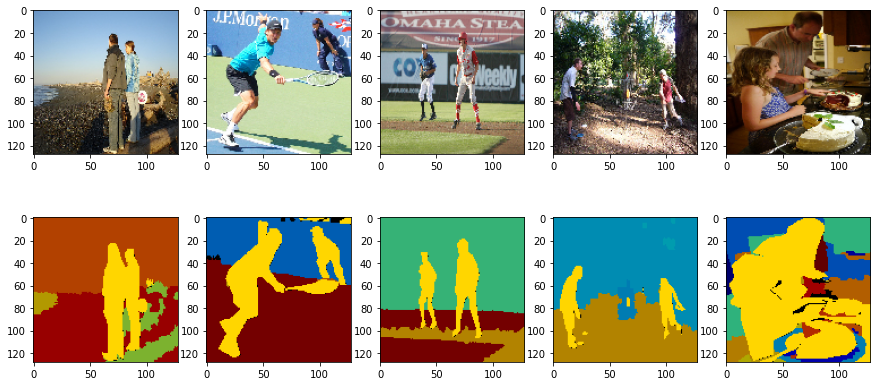

In [ ]:
images = [] # Создаем пустой список для хранений изображений обучающей выборки
segments = [] # Создаем пустой список для хранений меток

for filename in sorted(os.listdir(directory + 'img')): # Проходим по всем файлам в каталоге по указанному пути     
    images.append(image.load_img(os.path.join(directory + 'img',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список  

for filename in sorted(os.listdir(directory + 'seg')): # Проходим по всем файлам в каталоге по указанному пути     
    segments.append(image.load_img(os.path.join(directory + 'seg',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список 

n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(2, n, figsize=(15, 7)) # Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  indx =random.randint(0,len(images))
  axs[0,i].imshow(images[indx]) # Отображаем фото
  axs[1,i].imshow(segments[indx]) # Отображаем фото
plt.show() # Показываем изображения       

Обработка данных

In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (2 класса)
def color2index(color):
    index=0
    if (color[0]> 200) and  (color[1]  > 200)  : index = 1 # люди    
    return index  

In [ ]:
def index2color(index2):
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [0, 0, 0]  # фон
    elif index == 1:
        color = [255, 255, 0]  # люди
    return color 

In [ ]:
# Функция перевода индекса пикселя в to_categorical
def rgbToohe(y, num_classes): 
    y_shape = y.shape # Запоминаем форму массива для решейпа
    y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
    yt = [] # Создаем пустой лист
    for i in range(len(y)): # Проходим по всем трем канала изображения
        yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
    yt = np.array(yt) # Преобразуем в numpy
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) # Решейпим к исходныму размеру
    return yt # Возвращаем сформированный массив

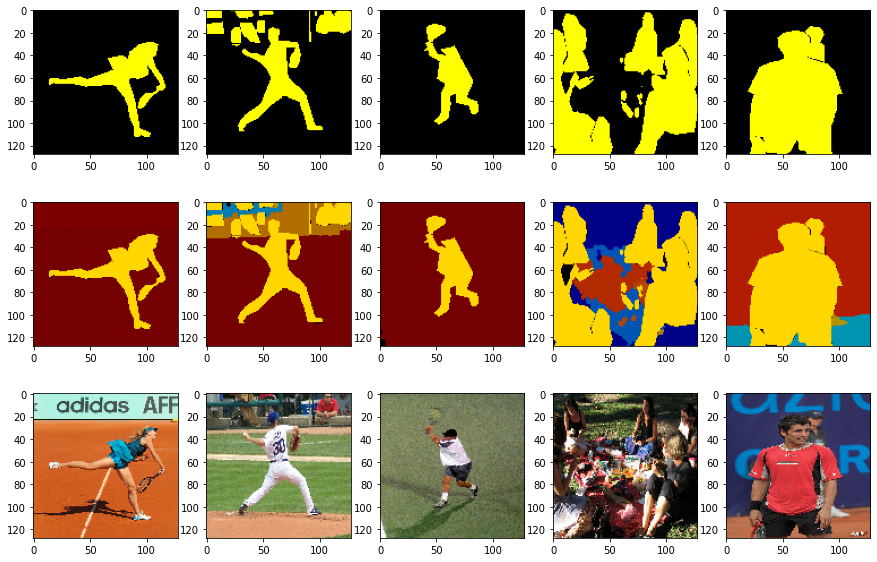

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(3, n, figsize=(15, 10)) # Создаем полотно из n графиков
for i in range(n): # Выводим в цикле по 5 изображений
    indx =random.randint(0,len(images))
    im = image.img_to_array(segments[indx]) # Переводим изображение в numpy-массив р змерностью: высота - ширина - количество каналов
    im = rgbToohe(im, num_classes) # Получаем OHE-представление сформированного массива

    im1 = [] # Пустой лист под сегментированную картинку 

    im = im.reshape(-1, num_classes) # Решейпим 
    for k in range(len(im)): # Проходим по всем уровням (количество классов)
      im1.append(index2color(im[k])) # Переводим индекс в пиксель

    im1 = np.array(im1) # Преобразуем в numpy
    im1 = im1.reshape(img_width, img_height,3) # Решейпим к размеру изображения  

    axs[0,i].imshow(im1)   # Преобразованный сегмент(ы)

    axs[1,i].imshow(segments[indx]) # сегмент 
    axs[2,i].imshow(images[indx])   # фото    
plt.show() #Показываем изображения

In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
    yTrain = [] # Создаем пустой список под карты сегметации
    for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
        y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
        y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
        yTrain.append(y) # Добавляем очередной элемент в yTrain
        if len(yTrain) % 100 == 0: # Каждые 100 шагов
            print(len(yTrain), end=' ') # Выводим количество обработанных изображений
    return np.array(yTrain) # Возвращаем сформированный yTrain

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in images: 
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размерность обучающей выборки

(648, 128, 128, 3)


In [ ]:
cur_time = time.time()
yTrain = yt_prep(segments, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c')

100 200 300 400 500 600 Время обработки:  141.39 c


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.11)
print(y_train.shape,y_val.shape)

(576, 128, 128, 2) (72, 128, 128, 2)


Создание модели

In [ ]:
def pspNet(num_classes = num_classes, input_shape= (img_width, img_height, 3)):
   
    img_input = Input(input_shape) 
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)
    x = Activation('relu')(x)

    # pooling пирамида
    block_1_out = MaxPooling2D((2,2))(x)
    block_2_out = MaxPooling2D((4,4))(x)
    block_3_out = MaxPooling2D((8,8))(x)
    block_4_out = MaxPooling2D((16,16))(x)

    # Сверточные слои
    block_1_out=Conv2D(64,(3,3),padding='same',name='block2_conv1')(block_1_out)
    block_1_out = Activation('relu')(block_1_out)
    block_2_out=Conv2D(64,(3,3),padding='same',name='block2_conv2')(block_2_out)
    block_2_out = Activation('relu')(block_2_out)
    block_3_out=Conv2D(64,(3,3),padding='same',name='block2_conv3')(block_3_out)
    block_3_out = Activation('relu')(block_3_out)
    block_4_out=Conv2D(64,(3,3),padding='same',name='block2_conv4')(block_4_out)
    block_4_out = Activation('relu')(block_4_out)

    # Увеличиваем размерность
    block_1_out=Conv2DTranspose(32,(3,3),strides=(2,2),padding='same')(block_1_out)
    block_1_out = Activation('relu')(block_1_out)
    block_2_out=Conv2DTranspose(32,(3,3),strides=(4,4),padding='same')(block_2_out)
    block_2_out = Activation('relu')(block_2_out)
    block_3_out=Conv2DTranspose(32,(3,3),strides=(8,8),padding='same')(block_3_out)
    block_3_out = Activation('relu')(block_3_out)
    block_4_out=Conv2DTranspose(32,(3,3),strides=(16,16),padding='same')(block_4_out)
    block_4_out = Activation('relu')(block_4_out)

    out = concatenate([block_1_out, block_2_out, block_3_out,block_4_out])      #объединяем слои
    out=Conv2D(num_classes,(3,3),activation='softmax',padding='same')(out)   # Выходной слой  с softmax-активацией

    model = Model(img_input, out) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    #model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])  #dice_coef
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])  #dice_coef

    
    return model # Возвращаем сформированную модель

In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [ ]:
model = pspNet()
history = model.fit(x_train, y_train,  epochs=20, batch_size=8, validation_data=(x_val, y_val)) # Обучаем модель 

Epoch 1/20
72/72 [==============================] - 104s 1s/step - loss: 0.5802 - dice_coef: 0.6466 - val_loss: 0.5104 - val_dice_coef: 0.6748
Epoch 2/20
72/72 [==============================] - 102s 1s/step - loss: 0.4791 - dice_coef: 0.6836 - val_loss: 0.5557 - val_dice_coef: 0.6362
Epoch 3/20
72/72 [==============================] - 102s 1s/step - loss: 0.4560 - dice_coef: 0.7017 - val_loss: 0.4686 - val_dice_coef: 0.6970
Epoch 4/20
72/72 [==============================] - 102s 1s/step - loss: 0.4356 - dice_coef: 0.7170 - val_loss: 0.5066 - val_dice_coef: 0.7136
Epoch 5/20
72/72 [==============================] - 102s 1s/step - loss: 0.4299 - dice_coef: 0.7206 - val_loss: 0.4569 - val_dice_coef: 0.7146
Epoch 6/20
72/72 [==============================] - 102s 1s/step - loss: 0.4333 - dice_coef: 0.7212 - val_loss: 0.4759 - val_dice_coef: 0.6644
Epoch 7/20
72/72 [==============================] - 102s 1s/step - loss: 0.4206 - dice_coef: 0.7268 - val_loss: 0.4624 - val_dice_coef: 0.7147

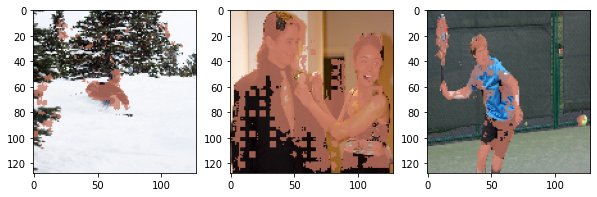

In [ ]:
indexes = np.random.randint(0, len(x_val), 3) # Получаем count случайных индексов
fig, axs = plt.subplots(1, 3, figsize=(10, 3)) # Создаем полотно из n графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    for k in range(len(pr)): # Проходим по всем уровням (количество классов)
        pr1.append(index2color(pr[k])) # Переводим индекс в пиксель
    pr1 = np.array(pr1) 
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')).convert('RGBA')

    mask = np.array(img)
    mask[mask[:,:,0] <= 10] = [0, 0, 0, 0]
    mask[mask[:,:,0] > 10] = [200, 120, 100, 200]
    imgm = Image.fromarray(mask).convert('RGBA')
    img = Image.fromarray(x_val[idx].astype('uint8'))
    img.paste(imgm, (0, 0),imgm)
    axs[i].imshow(img) # Отображаем на графике

plt.show() 

Попытаемся улучшить результат 

In [ ]:
def modUnet(num_classes = num_classes, input_shape= (img_width, img_height, 3)):  # Модифицированная Unet (облегчённый вариант)
                                                                                  # добавлены прямые и перекрестные связи
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out
    block_1_out_mask = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(block_1_out)     # Добавляем Conv2D-маску block_1_out_mask
    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out
    block_2_out_mask = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(block_2_out)     # Добавляем Conv2D-маску block_2_out_mask
    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(64, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation
    
    # UP 1
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем Conv2DTranspose-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_1_out_mask])                    # прямые и перекрестные связи

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем Conv2DTranspose-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_2_out_mask])                    # прямые и перекрестные связи

    x = Conv2D(32, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(num_classes,(3,3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                            # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                           # Возвращаем модель

In [ ]:
model = modUnet()
history = model.fit(x_train, y_train,  epochs=20, batch_size=8, validation_data=(x_val, y_val)) # Обучаем модель 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
72/72 [==============================] - 234s 3s/step - loss: 0.4944 - dice_coef: 0.6891 - val_loss: 0.6333 - val_dice_coef: 0.5603
Epoch 2/20
72/72 [==============================] - 230s 3s/step - loss: 0.4298 - dice_coef: 0.7236 - val_loss: 0.6660 - val_dice_coef: 0.5830
Epoch 3/20
72/72 [==============================] - 230s 3s/step - loss: 0.4075 - dice_coef: 0.7397 - val_loss: 0.4302 - val_dice_coef: 0.7462
Epoch 4/20
72/72 [==============================] - 230s 3s/step - loss: 0.3861 - dice_coef: 0.7553 - val_loss: 0.4260 - val_dice_coef: 0.7283
Epoch 5/20
72/72 [==============================] - 233s 3s/step - loss: 0.3871 - dice_coef: 0.7575 - val_loss: 0.4067 - val_dice_coef: 0.7251
Epoch 6/20
72/72 [==============================] - 231s 3s/step - loss: 0.3676 - dice_coef: 0.7670 - val_loss: 0.4550 - val_dice_coef: 0.6983
Epoch 7/20
72/72 [==============================] - 231s 3s/step - loss: 0.3576 - dice_coef: 0.7752 - val_loss: 0.6594 - val_dice_coef: 0.6179

Схема

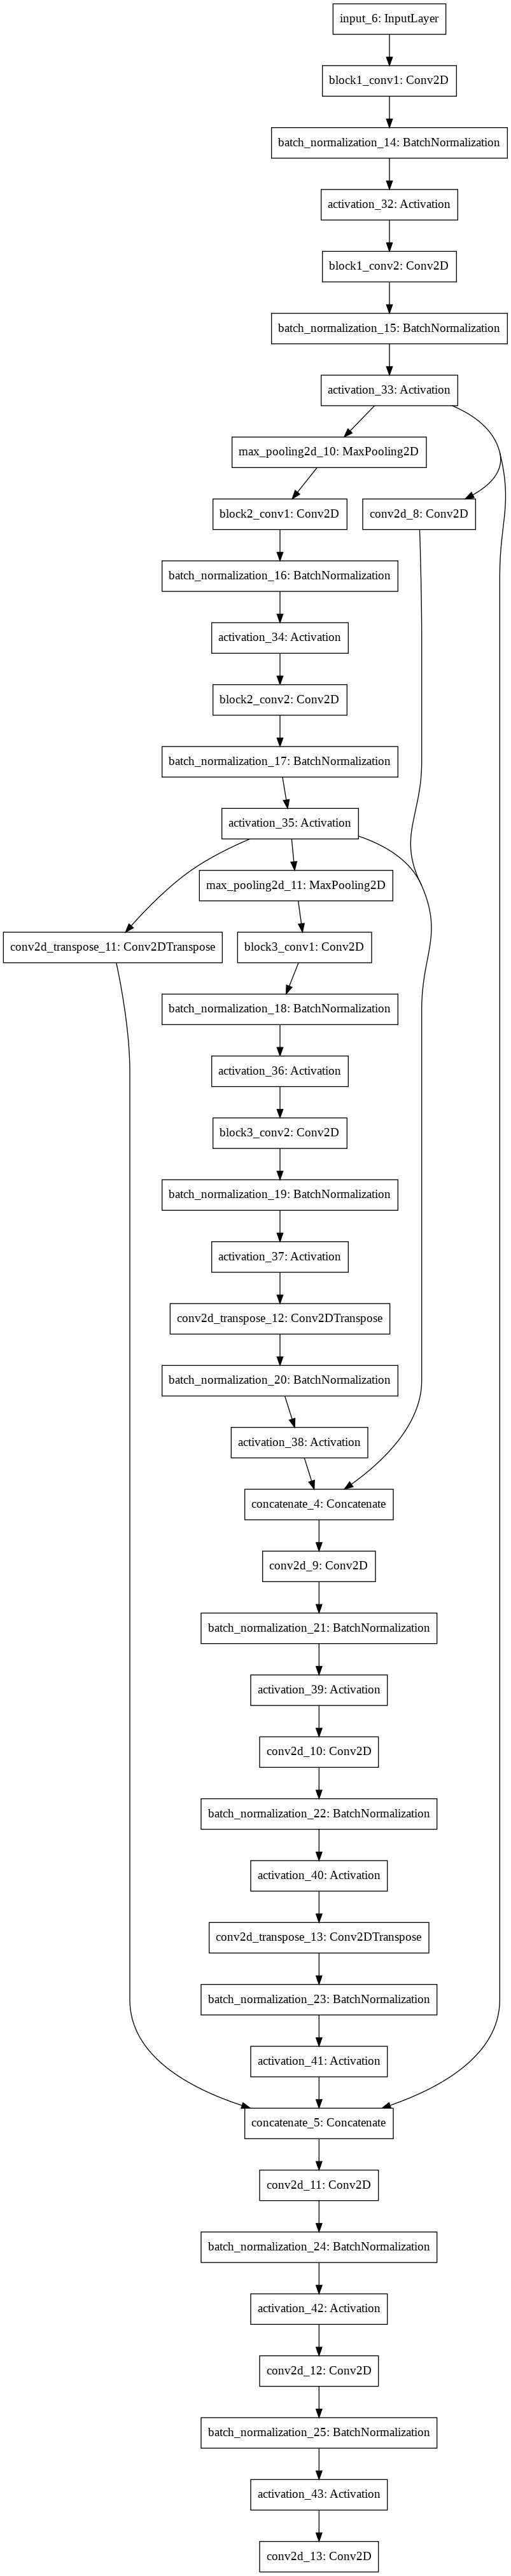

In [ ]:
plot_model(model)

In [ ]:
# Доучим с более мелким шагом
model.compile(optimizer=Adam(lr=2e-4), loss='categorical_crossentropy', metrics=[dice_coef])
history = model.fit(x_train, y_train,  epochs=10, batch_size=8, validation_data=(x_val, y_val)) # Обучаем модель 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
72/72 [==============================] - 234s 3s/step - loss: 0.2756 - dice_coef: 0.8271 - val_loss: 0.3393 - val_dice_coef: 0.8009
Epoch 2/10
72/72 [==============================] - 233s 3s/step - loss: 0.2650 - dice_coef: 0.8338 - val_loss: 0.3469 - val_dice_coef: 0.8003
Epoch 3/10
72/72 [==============================] - 233s 3s/step - loss: 0.2569 - dice_coef: 0.8396 - val_loss: 0.3732 - val_dice_coef: 0.8018
Epoch 4/10
72/72 [==============================] - 232s 3s/step - loss: 0.2562 - dice_coef: 0.8381 - val_loss: 0.3327 - val_dice_coef: 0.8080
Epoch 5/10
72/72 [==============================] - 243s 3s/step - loss: 0.2529 - dice_coef: 0.8425 - val_loss: 0.3374 - val_dice_coef: 0.8076
Epoch 6/10
72/72 [==============================] - 238s 3s/step - loss: 0.2432 - dice_coef: 0.8485 - val_loss: 0.3240 - val_dice_coef: 0.8083
Epoch 7/10
72/72 [==============================] - 240s 3s/step - loss: 0.2397 - dice_coef: 0.8513 - val_loss: 0.3459 - val_dice_coef: 0.8099

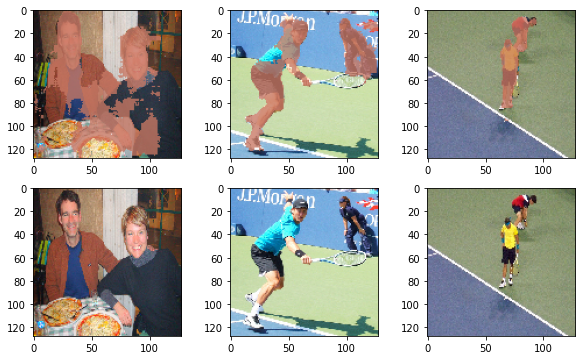

In [ ]:
indexes = np.random.randint(0, len(x_val), 3) # Получаем count случайных индексов
fig, axs = plt.subplots(2, 3, figsize=(10, 6)) # Создаем полотно из 3-x графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    for k in range(len(pr)): # Проходим по всем уровням (количество классов)
        pr1.append(index2color(pr[k])) # Переводим индекс в пиксель
    pr1 = np.array(pr1) 
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')).convert('RGBA')

    mask = np.array(img)
    mask[mask[:,:,0] <= 10] = [0, 0, 0, 0]
    mask[mask[:,:,0] > 10] = [200, 120, 100, 200]
    imgm = Image.fromarray(mask).convert('RGBA')
    img = Image.fromarray(x_val[idx].astype('uint8'))
    img.paste(imgm, (0, 0),imgm)
    axs[0,i].imshow(img) # Отображаем маску + фото
    axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8')))   # Отображаем  фото    

plt.show() 